In [1]:
#pip install gensim

In [2]:
import pandas as pd
import numpy as np
import gensim
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

In [3]:
data_maddow = pd.read_csv('data/Maddow_cleaned.tsv',sep='\t').drop(columns=['Unnamed: 0'])
data_carlson = pd.read_csv('data/Carlson_cleaned.tsv',sep='\t').drop(columns=['Unnamed: 0'])

In [4]:
pew = pd.read_excel('data/Pew Issue Polling 2022.xlsx')

In [5]:
# Load the Google News Vectors model
# downloaded from here https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300 

model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)


### Example use 

In [6]:
# Define a text
text = "This is an example of a text for semantic analysis."

# Tokenize the text into words
words = word_tokenize(text)

# Get the vector representation of each word
vectors = [model[word] for word in words if word in model]

# Aggregate the word vectors to obtain a representation of the text as a whole
text_vector = sum(vectors) / len(vectors)


### Select which transcript column to run with 

In [7]:
#data_selection = 'transcript'
data_selection = 'stop words removed'
#data_selection = 'stop words and lemmatization'

### Weighting the word vector by the TF-IDF score

In [8]:
def weighted_vectors(data):

    # Convert the text data into a matrix of TF-IDF features
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(data[data_selection].tolist())

    # Weight the word vectors based on their TF-IDF scores
    word_index = vectorizer.vocabulary_
    word_vectors = np.zeros((len(word_index), 300))
    for word, index in word_index.items():
        try:
            word_vectors[index, :] = model[word] * tfidf[0, index]
        except KeyError:
            pass
        
    return word_vectors, word_index

In [9]:
maddow_word_vectors, maddow_word_index = weighted_vectors(data_maddow)
carlson_word_vectors, carlson_word_index = weighted_vectors(data_carlson)

### Mean transcript word vector per transcript

In [10]:
def mean_doc_vector(data, word_vectors, word_index):

    # Initialize the matrix to store the document vectors
    doc_vector_words = np.zeros((data.shape[0], 300))
    doc_vector_avg = []

    # Compute the document vectors as the mean of the weighted word vectors
    for i, row in data.iterrows():
        words = row[data_selection].split()
        for word in words:
            if word in word_index:
                doc_vector_words[i, :] += word_vectors[word_index[word], :]
        doc_vector_words[i, :] /= len(words)
        doc_vecor_avg = doc_vector_avg.append(doc_vector_words[i,:])

    data['average tfidf weighted vec'] = doc_vector_avg
    
    return data


    


In [11]:
data_maddow = mean_doc_vector(data_maddow, maddow_word_vectors, maddow_word_index)
data_carlson = mean_doc_vector(data_carlson, carlson_word_vectors, carlson_word_index)

### Average vector for pew vocabulary

In [12]:
# remove the commas in order to tokenize properly 
average_wvec = []
pew['expanded dict'] = [string.replace(',', ' ') for string in pew['expanded dict']]

for i, row in pew.iterrows():
    
    # tokenize the string into words
    words = word_tokenize(row['expanded dict'])
    # initiate a word vector per word 
    pew_vectors = np.zeros((len(words), 300))
    
    for index, word in enumerate(words):
        try:
            pew_vectors[index] = model[word]
        except KeyError:
            pass
        
    # store the average word vec in the pew df    
    average_wvec.append( np.sum(pew_vectors, axis = 0)/len(pew_vectors))
    
pew['average_wvec'] = average_wvec
    



In [13]:
# removing due to all 0 word vectors - can leave these in once the string in pew is updated
pew = pew.drop([4,7,9,10,15])

In [14]:
pew.reset_index(inplace = True)

## Similarity 

In [15]:
def cosine_similarity_vec(data):

    # Compute the cosine similarity between each pair of average document vectors and pew vector

    # establish a column per issue to store the cosine similarity score
    for index, issue in enumerate(pew.issue):
        cos_score = []
        for i, row in data.iterrows():
            wvec_document = row['average tfidf weighted vec'].reshape(1, -1)
            wvec_pew = pew[pew['issue']== issue]['average_wvec'][index].reshape(1, 300)
            cos_score.append(cosine_similarity( wvec_document, wvec_pew)[0][0])

        data[issue]=cos_score
        
    return data 
        

    

In [16]:
data_maddow = cosine_similarity_vec(data_maddow)
data_carlson = cosine_similarity_vec(data_carlson)

### Plot Cosine similarity over time 

In [17]:
def similarity_lineplot(data, issue): 
    issues = pew.issue

    x = data['timestamp']
    y = data[issue]

    plt.plot(x,y)
    plt.title(issue)
    
    return plt.show()

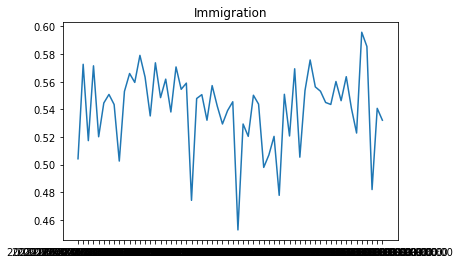

In [18]:
similarity_lineplot(data_maddow , pew.issue[2])

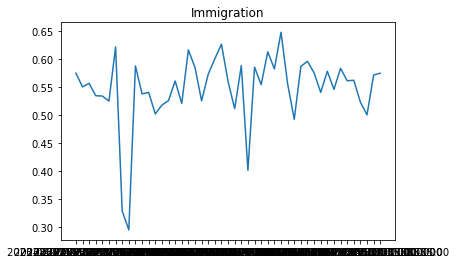

In [19]:
similarity_lineplot(data_carlson , pew.issue[2])

### Simple calssifier

In [20]:
def simple_classifier(data): 
    
    # take the subset of data that stores the cosine similarity value per issue
    subset = data[list(pew.issue)]

    # save the classification result as the max cosine similarity score per issue
    data['classification'] = subset.idxmax(axis=1)
    
    return data


In [21]:
data_maddow = simple_classifier(data_maddow)
data_carlson = simple_classifier(data_carlson)

In [22]:
def frequency_bar(data): 
    
    # create a bar plot showing the frequency of each column name
    fig, ax = plt.subplots()
    data['classification'].value_counts().plot(kind='bar', ax=ax)
    ax.set_xlabel('Issue')
    ax.set_ylabel('Frequency')
    ax.set_title('Top issue based on cosine similarity: ' + host)
    
    return plt.show()
    
    

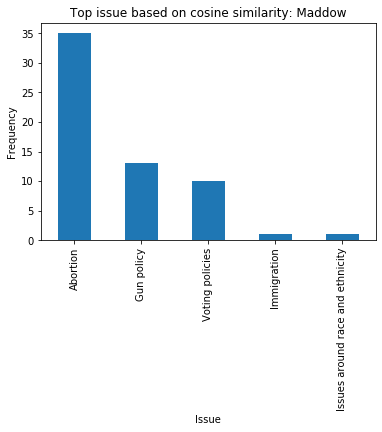

In [23]:
frequency_bar(data_maddow, 'Maddow')

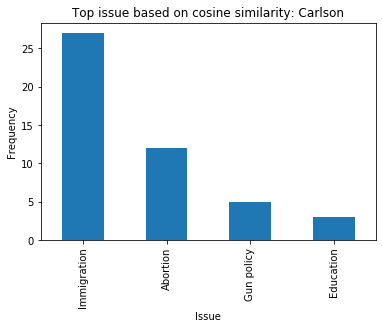

In [24]:
frequency_bar(data_carlson, 'Carlson')

In [ ]:
# add a new column to specify the dataframe
data_maddow['source'] = 'Maddow'
data_carlson['source'] = 'Carlson'

# concatenate the two dataframes vertically
result = pd.concat([data_maddow[['classification', 'source']], data_carlson[['classification', 'source']]], axis=0)

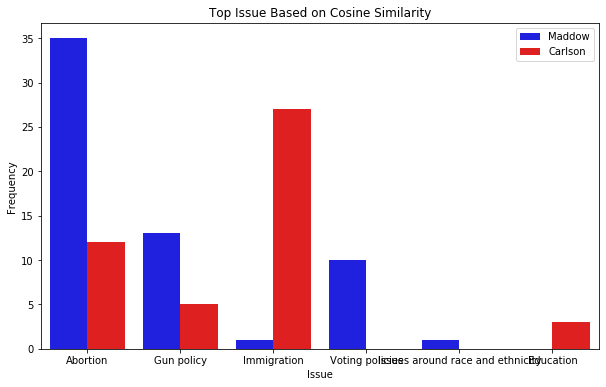

In [35]:
# create a combined view
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='classification', hue='source', data=result, ax=ax, palette=['blue', 'red'])

# set the axis labels and title
ax.set_xlabel('Issue')
ax.set_ylabel('Frequency')
ax.set_title('Top Issue Based on Cosine Similarity')

# move the legend to the upper right corner
ax.legend(loc='upper right')

# show the plot
plt.show()

In [25]:
def heatmap_func(data, host):
    
    # pull the relevant subset of data 
    subset = pew.issue
    subset.append(pd.Series(['classification']))
    subset = data[list(subset)]
    
    # Heatmap
    sns.heatmap(subset.corr(), annot=False, cmap='coolwarm', vmin=-0.5, vmax=1)
    plt.title('Cosine Similarity Heatmap: '+ host)
    
    return plt.show()

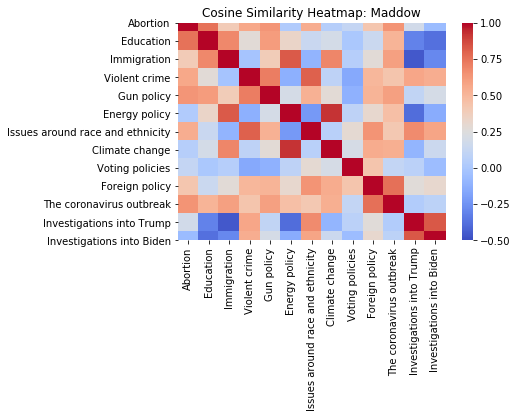

In [26]:
heatmap_func(data_maddow, "Maddow")

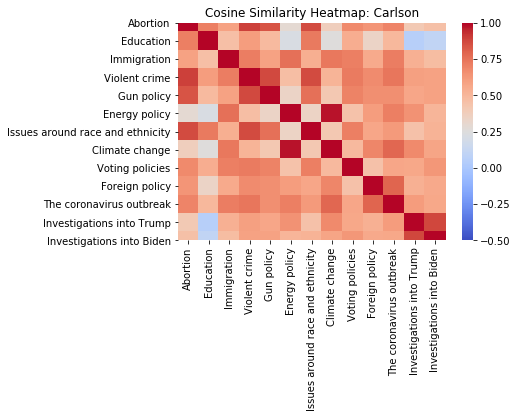

In [27]:
heatmap_func(data_carlson, "Carlson")